# DIY Covid-19 Dashboard (UK)

### Section 1. Import Libraries and Set Up

These imports include essential libraries for data handling, visualization, and interactivity.

In [1]:
!pip install uk-covid19
from uk_covid19 import Cov19API  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import ipywidgets as wdg  
import json  
from IPython.display import display, clear_output  

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

### Section 2. Data collection

Accessing and fetching data from the UK COVID-19 API

In [3]:
def access_api():
    """
    It retrieves data on cases and reinfections for England COVID-19 data using the Cov19API library.
    """
    filters = [
        'areaType=nation',
        'areaName=England'
    ]
    structure = {
        "date": "date",
        "cases": "newCasesBySpecimenDateRollingRate",
        "tests": "newReinfectionsBySpecimenDateRollingRate"
    }
    api = Cov19API(filters=filters, structure=structure)
    timeseries = api.get_json()  
    return timeseries

Loading locally saved JSON data for initial setup (to avoid API limit issues).

In [4]:
with open('timeseries.json', 'r') as timeseries_file:
    jsondata = json.load(timeseries_file)

### Section 3. Data Wrangling

In [5]:
def parse_date(datestring):
    """
    Ensuring consistency in date formatting
    """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [6]:
def wrangle_data(jsondata):
    
    datalist = jsondata['data']  
    dates = [dictionary['date'] for dictionary in datalist]  
    dates.sort()
    startdate = parse_date(dates[0])  
    enddate = parse_date(dates[-1])  

    index = pd.date_range(startdate, enddate, freq='D')
    timeseriesdf = pd.DataFrame(index=index, columns=['cases', 'tests'])

    for entry in datalist:
        date = parse_date(entry['date'])
        for column in ['cases', 'tests']:
            if pd.isna(timeseriesdf.loc[date, column]):  
                value = float(entry[column]) if entry[column] is not None else 0.0
                timeseriesdf.loc[date, column] = value

    timeseriesdf.fillna(0.0, inplace=True)
    return timeseriesdf

In [7]:
timeseriesdf = wrangle_data(jsondata)

### Section 4: Interactive Widgets

In [10]:
# Dropdown widget to select between cases and tests
whichwalk = wdg.Dropdown(
    options=['cases', 'tests', 'both'],
    value='cases',
    description='Stats: ',
    disabled=False,
)

# Refresh button widget to fetch updated data
apibutton = wdg.Button(
    description='Refresh',
    disabled=False,
    button_style='info',  
    tooltip="Refresh the data from the API",
    icon='refresh'
)

def refresh_graph():
    """
    Updates the graph by redrawing it based on the current selection in the widget.
    """
    current = whichwalk.value
    if current == whichwalk.options[0]:
        other = whichwalk.options[1]
    else:
        other = whichwalk.options[0]
    whichwalk.value = other
    whichwalk.value = current  

def api_button_callback(button):
    """
    This is the callback function for the Refresh button, which attempts to retrieve the most recent data from the API; 
    if the API request fails, it defaults to using the local JSON file.
    """
    global timeseriesdf
    try:
        apidata = access_api()  
        timeseriesdf = wrangle_data(apidata)  
        apibutton.icon = "check"  
        apibutton.tooltip = "Data refreshed from API successfully!"
    except Exception as e:
        print(f"API request failed: {e}")
        with open('timeseries.json', 'r') as timeseries_file:
            jsondata = json.load(timeseries_file)
            timeseriesdf = wrangle_data(jsondata)
        apibutton.icon = "exclamation-triangle"  
        apibutton.tooltip = "Failed to refresh from API; using local data instead."
    
    refresh_graph()
    apibutton.disabled = False

apibutton.on_click(api_button_callback)

### Section 5: Graphs and Visualizations

In [11]:
def timeseries_graph(graph):
    """
    Function to plot the selected metric ('cases', 'tests', or both) over time.
    """
    if graph == 'both':
        y = ['cases', 'tests']
        title = "COVID-19 Cases and Tests Over Time"
    else:
        y = [graph]
        title = f"COVID-19 {graph.capitalize()} Over Time"
    
    timeseriesdf.plot(kind='line', y=y, title=title)
    plt.xlabel("Date")
    plt.ylabel("Rolling Rate")
    plt.show()

graph = wdg.interactive_output(timeseries_graph, {'graph': whichwalk})
display(whichwalk, apibutton, graph)

Dropdown(description='Stats: ', options=('cases', 'tests', 'both'), value='cases')

Button(button_style='info', description='Refresh', icon='refresh', style=ButtonStyle(), tooltip='Refresh the d…

Output()

#### Summary Statistics

In [12]:
def show_summary():
    """
    Display key statistics, such as total cases, max daily cases, and 7-day average.
    """
    cases = pd.to_numeric(timeseriesdf['cases'], errors='coerce')
    total_cases = cases.sum()
    max_daily_cases = cases.max()
    max_date = cases.idxmax().strftime('%Y-%m-%d')
    current_cases = cases.iloc[-1]
    rolling_avg = cases.rolling(window=7).mean().iloc[-1]

    summary = f"""
    Total Cases: {total_cases:,.0f}
    Peak Daily Cases: {max_daily_cases:,.0f} on {max_date}
    Current Daily Cases: {current_cases:,.0f}
    Current 7-Day Average: {rolling_avg:.2f}
    """
    display(wdg.HTML(value=f"<pre><b>{summary}</b></pre>"))

show_summary()

HTML(value='<pre><b>\n    Total Cases: 260,056\n    Peak Daily Cases: 2,204 on 2022-01-04\n    Current Daily C…

#### Percent change analysis

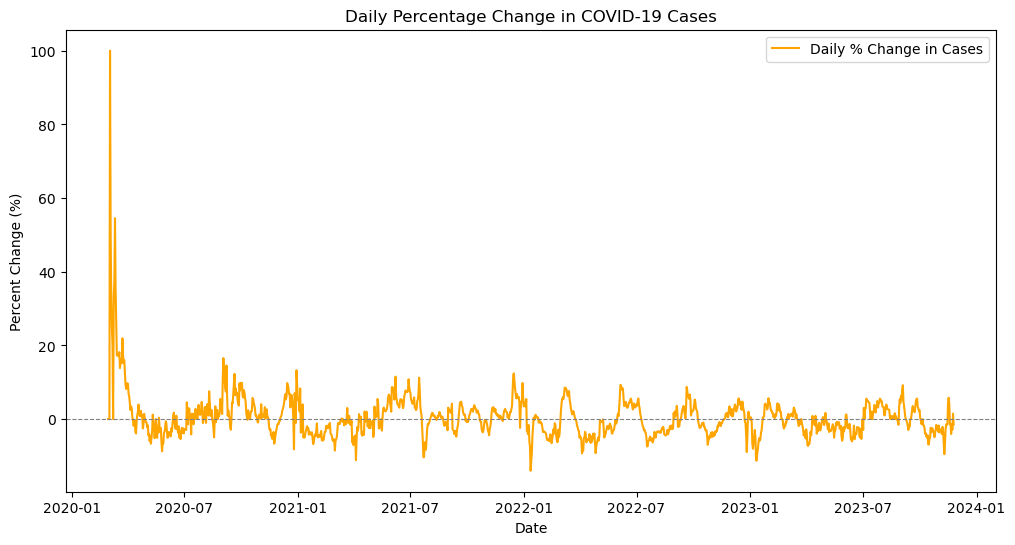

In [13]:
timeseriesdf['cases_pct_change'] = timeseriesdf['cases'].pct_change() * 100

def plot_percent_change():
    plt.figure(figsize=(12, 6))
    plt.plot(timeseriesdf.index, timeseriesdf["cases_pct_change"], label="Daily % Change in Cases", color='orange')
    plt.title("Daily Percentage Change in COVID-19 Cases")
    plt.xlabel("Date")
    plt.ylabel("Percent Change (%)")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add a horizontal line at 0 for reference
    plt.legend()
    plt.show()

plot_percent_change()

#### Function to highlight significant events

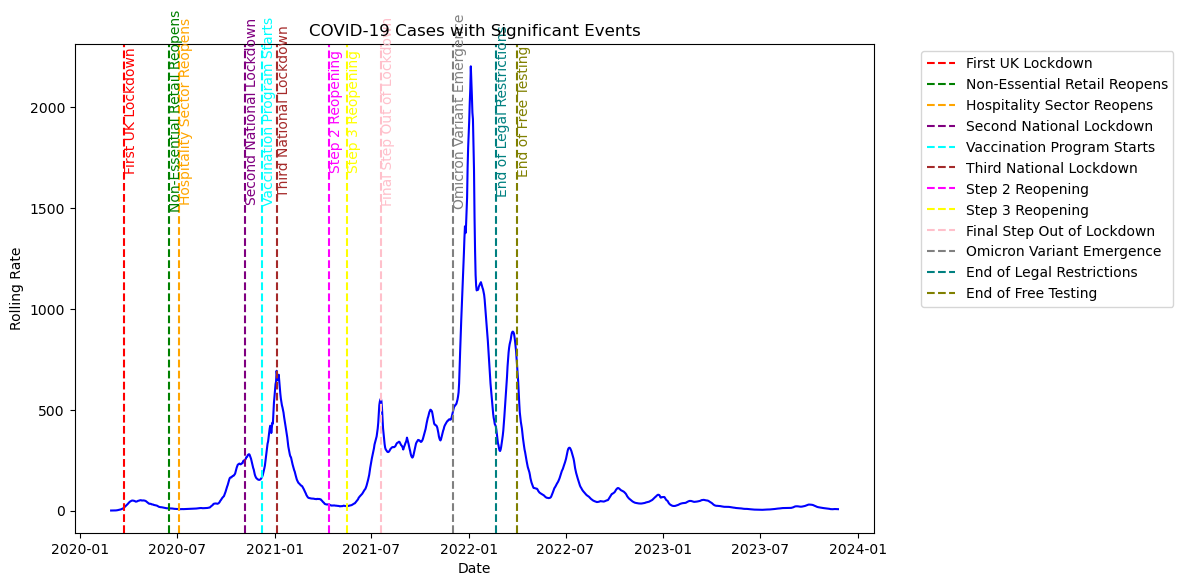

In [14]:
def plot_with_events():
    plt.figure(figsize=(12, 6))
    cases = pd.to_numeric(timeseriesdf["cases"], errors='coerce')
    plt.plot(timeseriesdf.index, cases, label="Cases", color='blue')
    
    # Defining events
    events = {
        "2020-03-23": ("First UK Lockdown", "red", "--"),
        "2020-06-15": ("Non-Essential Retail Reopens", "green", "--"),
        "2020-07-04": ("Hospitality Sector Reopens", "orange", "--"),
        "2020-11-05": ("Second National Lockdown", "purple", "--"),
        "2020-12-08": ("Vaccination Program Starts", "cyan", "--"),
        "2021-01-04": ("Third National Lockdown", "brown", "--"),
        "2021-04-12": ("Step 2 Reopening", "magenta", "--"),
        "2021-05-17": ("Step 3 Reopening", "yellow", "--"),
        "2021-07-19": ("Final Step Out of Lockdown", "pink", "--"),
        "2021-12-01": ("Omicron Variant Emergence", "gray", "--"),
        "2022-02-21": ("End of Legal Restrictions", "teal", "--"),
        "2022-04-01": ("End of Free Testing", "olive", "--")
    }
    
    for date, (event_name, color, linestyle) in events.items():
        plt.axvline(x=pd.to_datetime(date), color=color, linestyle=linestyle, label=event_name)
        plt.text(pd.to_datetime(date), cases.max()*0.9, event_name, rotation=90, verticalalignment='center', color=color)

    plt.title("COVID-19 Cases with Significant Events")
    plt.xlabel("Date")
    plt.ylabel("Rolling Rate")
    
    handles = [plt.Line2D([0], [0], color=color, linestyle=linestyle) for _, (event_name, color, linestyle) in events.items()]
    labels = [event_name for _, (event_name, _, _) in events.items()]
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_with_events()


### Summary of visualization

Dropdown(description='Stats: ', options=('cases', 'tests', 'both'), value='cases')

Button(button_style='info', description='Refresh', icon='refresh', style=ButtonStyle(), tooltip='Refresh the d…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

HTML(value='<pre><b>\n    Total Cases: 260,056\n    Peak Daily Cases: 2,204 on 2022-01-04\n    Current Daily C…

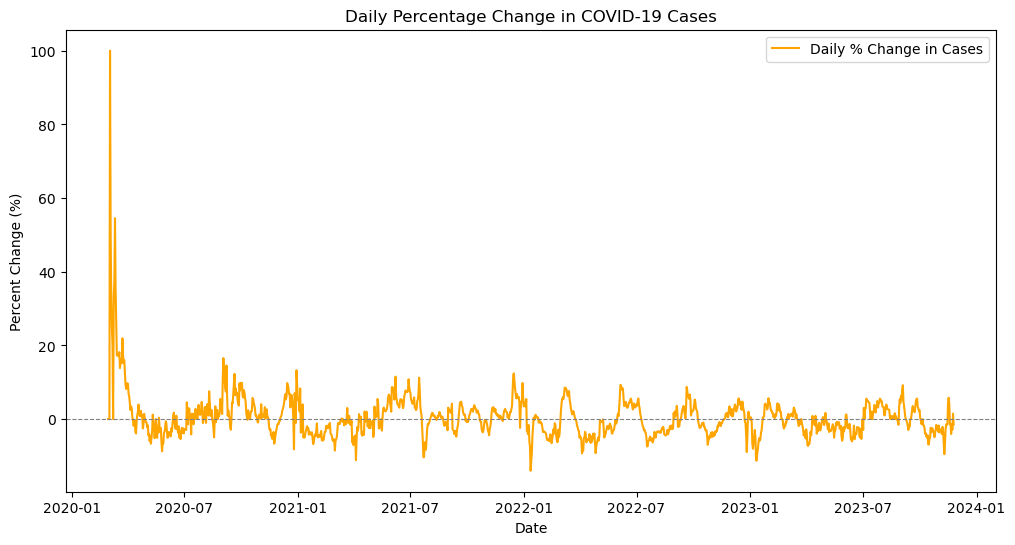

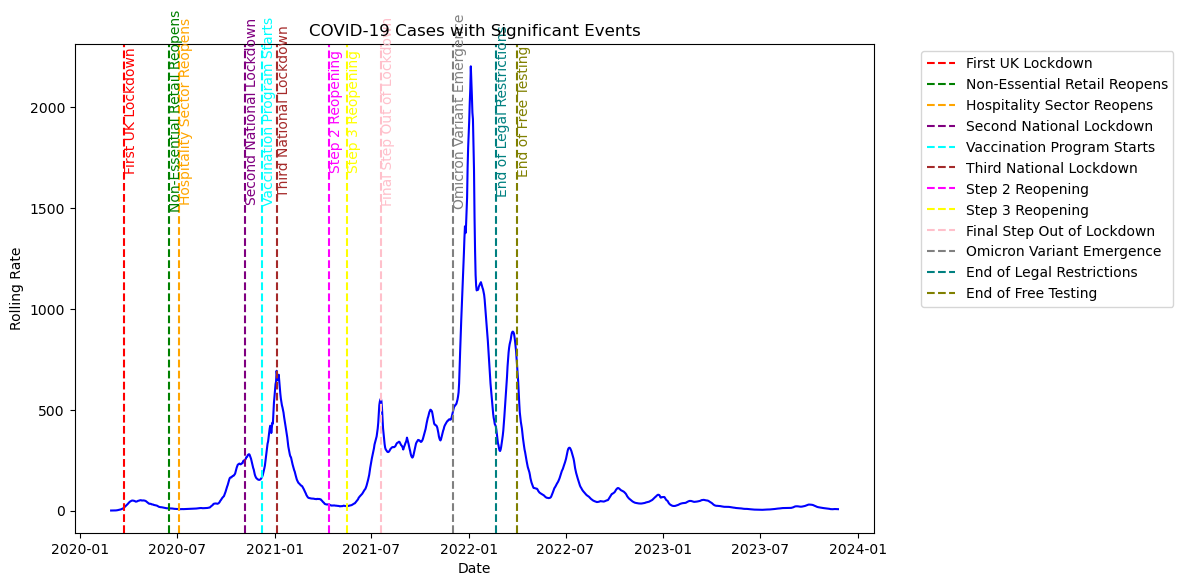

In [15]:
display(whichwalk, apibutton, graph)
show_summary()
plot_percent_change()
plot_with_events()

**Author and Copyright Notice**
This dashboard is an extension of the DIY Covid Dashboard Kit, originally developed by Fabrizio Smeraldi. Modifications and enhancements were made by Adina Nabi, as part of a computer programming module.
The data is based on UK Government [data](https://coronavirus.data.gov.uk/) published by [Public Health England](https://www.gov.uk/government/organisations/public-health-england) and on the [DIY Covid Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash), Copyright (C) Fabrizio Smeraldi 2020,2023. Released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/).